### Introduction
Within this Jupyter notebook, I replicate a delta-hedged approach for a one-year, long-call European option. The emphasis will be on exploring the correlation between the outcomes of the hedging strategy and the frequency of delta rebalancing. Ultimately, I will demonstrate that the variance of the hedging strategy conforms to an inverse square root pattern in relation to the rebalancing frequency.

#### 0) Simulation parameters

In [49]:
# Simulation general parameters
NDAYS_YEAR      = 252 # number of trading days per year
N_SIMS          = 2000 # number of simulations
REBAL_FREQ      = 1/(252*1) # frequency of rebalancing


# Simulation underlying parameters
INI_PRICE       = 100 # stock initial price
STRIKE_PRICE    = 100 # strike price
YEARS_TO_EXP    = 1   # years until expiration
DRIFT           = 0.0 # stocks drift
ANNUALIZED_VOL  = 0.2 # process volatility
RISK_FREE_RATE  = 0.0 # risk-free rate


#### 00) Libraries

In [74]:
# Load needed libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm, lognorm
from sklearn.linear_model import LinearRegression
from IPython.display import display
from PIL import Image

mpl.rcParams['figure.dpi']= 250

#### 000) Black-Scholes functions

In [51]:
# Define Black-Scholes functions for call option

def calculate_call_delta(S, K, r, T, sigma):
    """
    Calculate the delta of an European call option using the Black-Scholes formula.

    Parameters:
    S (float): Current stock price.
    K (float): Strike price.
    r (float): Risk-free rate.
    T (float): Time to maturity (in years).
    sigma (float): Volatility.

    Returns:
    float: Delta of the call option.
    """
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)

    return delta


def calculate_call_price(S, K, r, T, sigma):
    """
    Calculate the price of an European call option using the Black-Scholes formula.

    Parameters:
    S (float): Current stock price.
    K (float): Strike price.
    r (float): Risk-free rate.
    T (float): Time to maturity (in years).
    sigma (float): Volatility.

    Returns:
    float: Price of the call option.
    """

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    #price = np.maximum(S - K, 0) if T==0 else S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

    N_d1 = 0.5 * (1 + math.erf(d1 / np.sqrt(2)))
    N_d2 = 0.5 * (1 + math.erf(d2 / np.sqrt(2)))

    price = S * N_d1 - K * np.exp(-r * T) * N_d2
    
    return price


#### 1) Simulate the Brownian process

Returns will be simulated according to a lognormal distribution. Assuming the lognormal distribution of our process is characterized by a mean ($\mu$) and a standard deviation ($\sigma$), the anticipated value of the random variable would equate to $e^{\mu + \sigma^2/2}$. It's crucial to recognize that even when there is no drift (i.e., $\mu = 0$), the expected value would still be influenced by the variance ($e^{\sigma^2/2}$). As a result, for generating stock price paths with zero drift, it becomes necessary to substract $\sigma^2/2$ from the random variable. Failing to do so would lead to stock price paths exhibiting a drift.

In [52]:
# Step volatility
daily_vol = ANNUALIZED_VOL*np.sqrt(REBAL_FREQ)

# Create a log-normal distribution object (sigma^2/2 is substracted from the mean)
lognorm_dist = lognorm(s = daily_vol, 
                       scale = np.exp(DRIFT - 0.5*(daily_vol)**2))

# Dataframe containing simulated paths
dfPaths = pd.DataFrame(np.nan, 
                       index = np.arange(start = YEARS_TO_EXP, stop = 0.0, step = -REBAL_FREQ), 
                       columns = [f'Path{i}' for i in range(1, N_SIMS+1)])

# Initial price is fixed
dfPaths.iloc[0, :] = INI_PRICE

# Generate random values for all steps in one go
random_values = np.random.rand(dfPaths.shape[0] - 1, dfPaths.shape[1])

# Calculate the new values using vectorized operations
for idx in range(dfPaths.shape[0]-1):
    dfPaths.iloc[idx+1, :] = dfPaths.iloc[idx,:]*lognorm_dist.ppf(random_values[idx,:])

Let's plot the simulated paths and the last price distribution after one year.

Text(0.5, 1.0, 'Simulated last price distribution')

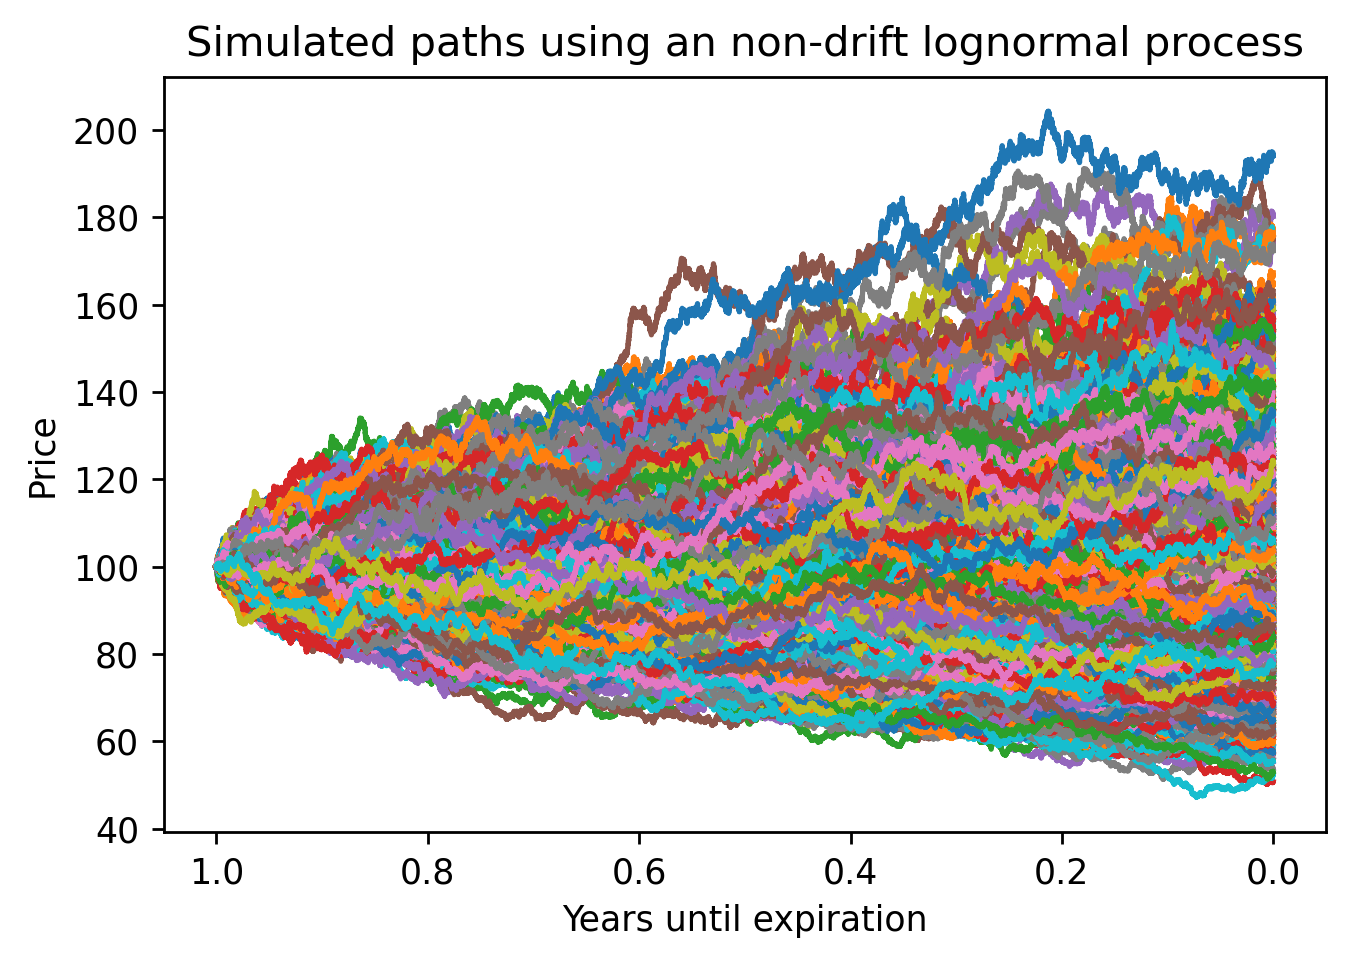

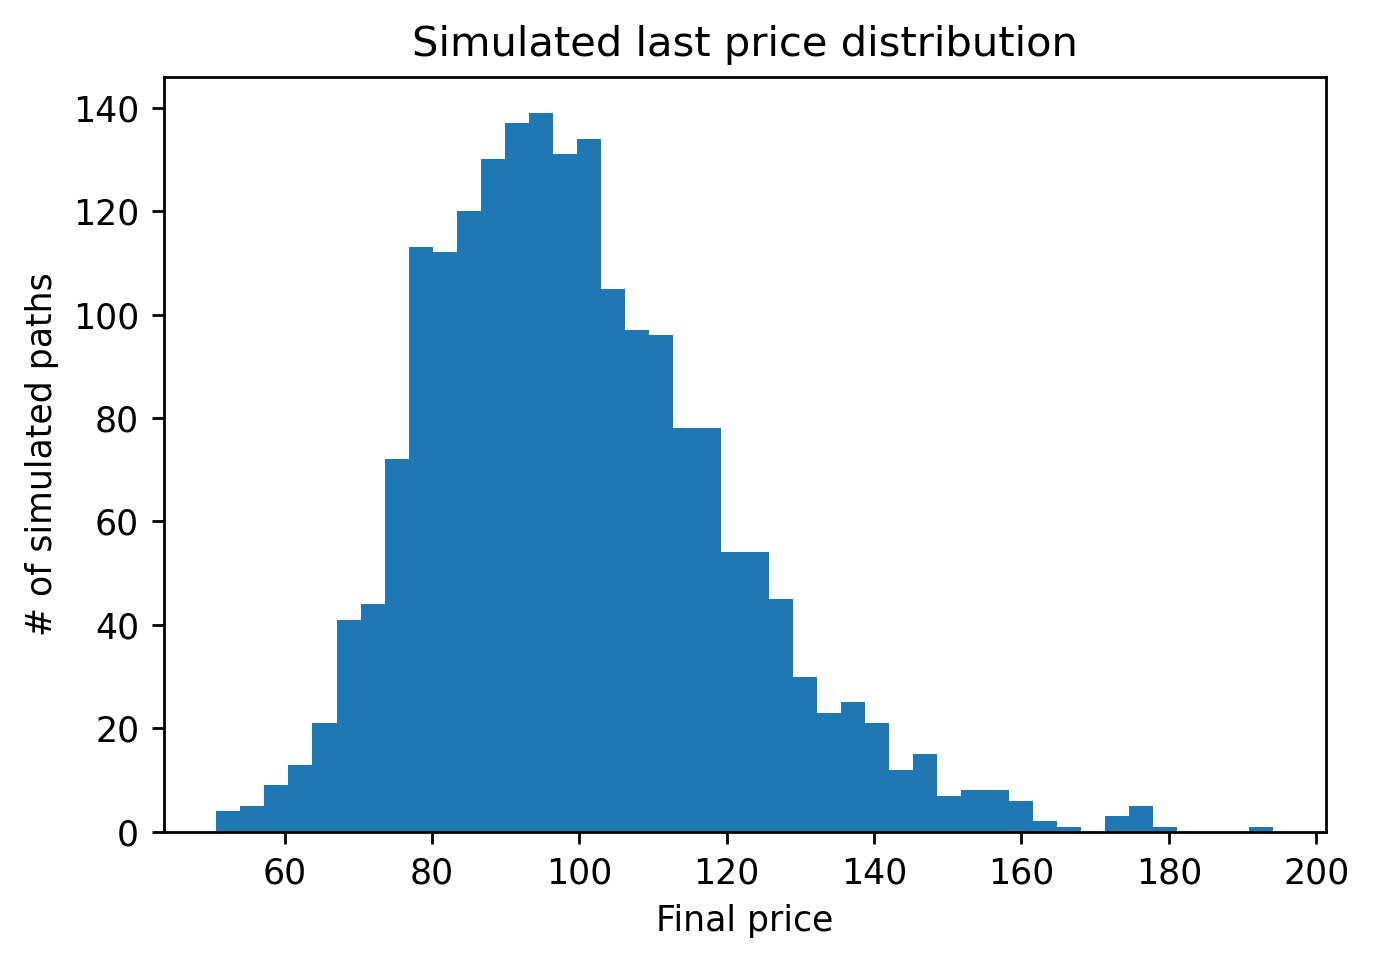

In [53]:
# Plot the stock paths
dfPaths.plot(legend = False)
plt.gca().invert_xaxis()
plt.xlabel('Years until expiration')
plt.ylabel('Price')
plt.title('Simulated paths using an non-drift lognormal process')

# Plot the last price distribution
fig, ax = plt.subplots()
dfPaths.iloc[-1,:].plot.hist(bins = int(np.sqrt(N_SIMS)), legend = False)
plt.xlabel('Final price')
plt.ylabel('# of simulated paths')
plt.title('Simulated last price distribution')


#### 2) Compute the call option delta and the hedging PnL

The call option that I will simulate has an strike equal to 100. The risk-free rate will be assumed to be zero. Hedging PnL will be computed at each step taking into account previous option delta and the price difference.

In [54]:
# Dataframe containing call delta
dfDelta = pd.DataFrame(np.nan, 
                       index = np.arange(start = YEARS_TO_EXP, stop = 0.0, step = -REBAL_FREQ), 
                       columns = [f'Delta for path{i}' for i in range(1, N_SIMS+1)])

# Dataframe containing hedging PnL
dfHedgingPnL = pd.DataFrame(np.nan, 
                            index = np.arange(start = YEARS_TO_EXP, stop = 0.0, step = -REBAL_FREQ), 
                            columns = [f'Hedging PnL for path{i}' for i in range(1, N_SIMS+1)])

# Go across each path and compute delta and hedging PnL
for idx_step in range(dfPaths.shape[0]):

    dfDelta.iloc[idx_step, :] = calculate_call_delta(dfPaths.iloc[idx_step, :], 
                                                    STRIKE_PRICE, 
                                                    RISK_FREE_RATE, 
                                                    dfPaths.index[idx_step], 
                                                    ANNUALIZED_VOL)
        
    if idx_step != 0:
        dfHedgingPnL.iloc[idx_step, :] = -dfDelta.iloc[idx_step-1, :].values*\
                                            (dfPaths.iloc[idx_step, :] - dfPaths.iloc[idx_step-1, :])

#### 3) Show the PnL distribution for a delta-hedged call option

I will check if delta-hedging is working as supposed. That is, let's see if the total PnL (hedging PnL + option PnL) follows a Gaussian distribution centered at zero.

In [55]:
# Dataframe containing total PnL at each step
dfTotPnL = pd.DataFrame(np.nan, 
                        index = np.arange(start = YEARS_TO_EXP, stop = 0.0, step = -REBAL_FREQ), 
                        columns = [f'Total PnL for path{i}' for i in range(1, N_SIMS+1)])

# Go across each path and compute total PnL (option PNL + hedging PnL)  
dfHedgingPnL_cumsum = dfHedgingPnL.cumsum(axis=0)
positive_diff = np.maximum(dfPaths.values - STRIKE_PRICE, 0)

for idx_step in range(dfPaths.shape[0]):
    dfTotPnL.iloc[idx_step, :] = dfHedgingPnL_cumsum.iloc[idx_step, :].values + positive_diff[idx_step, :]


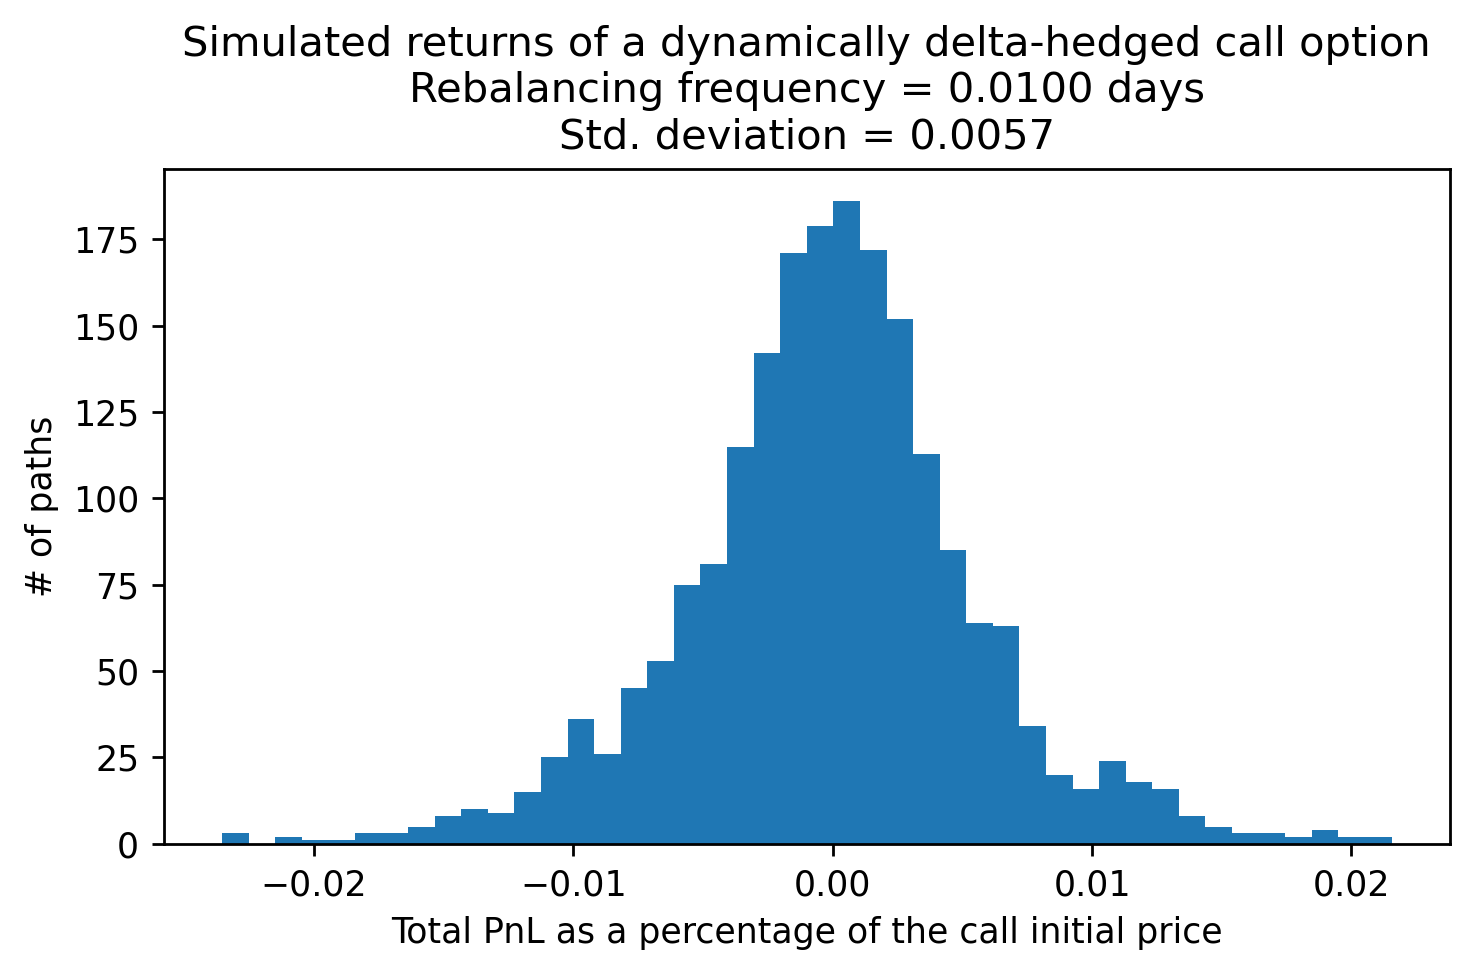

In [56]:
# Plot an histogram with the returns of an dynamically delta-hedged call option
# PnL will be shown as a portion of the call premium

call_init_price = calculate_call_price(INI_PRICE, STRIKE_PRICE, 0.0, YEARS_TO_EXP, ANNUALIZED_VOL)

fig, ax = plt.subplots()
returns_dist = dfTotPnL.iloc[-1,:]/call_init_price - 1
returns_dist.plot.hist(bins = int(np.sqrt(N_SIMS)), legend = False)
plt.xlabel('Total PnL as a percentage of the call initial price')
plt.ylabel('# of paths')
plt.title('Simulated returns of a dynamically delta-hedged call option\n' +\
            'Rebalancing frequency = ' + "{:.4f}".format(REBAL_FREQ*NDAYS_YEAR) + ' days\n' +\
            'Std. deviation = ' + "{:.4f}".format(returns_dist.std()))
plt.tight_layout()
plt.savefig('figs/PnL_distribution_' + "{:.4f}".format(REBAL_FREQ*NDAYS_YEAR) + '.png')

#### 4) Results analysis

First, let's plot the PnL distribution for different frequencies of delta-hedging

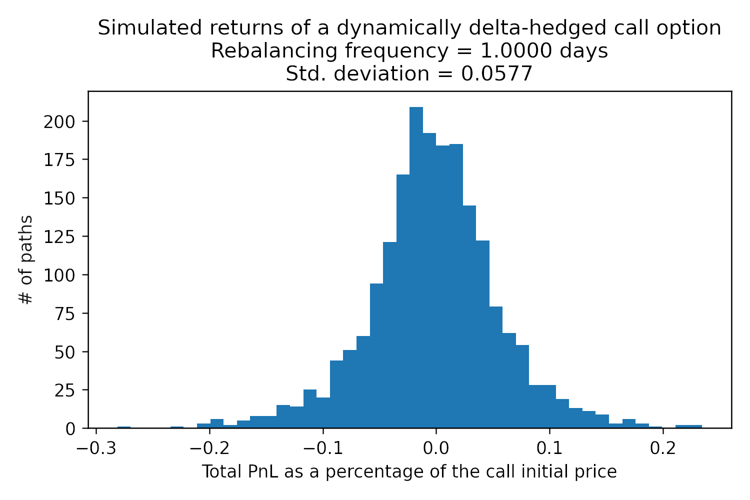

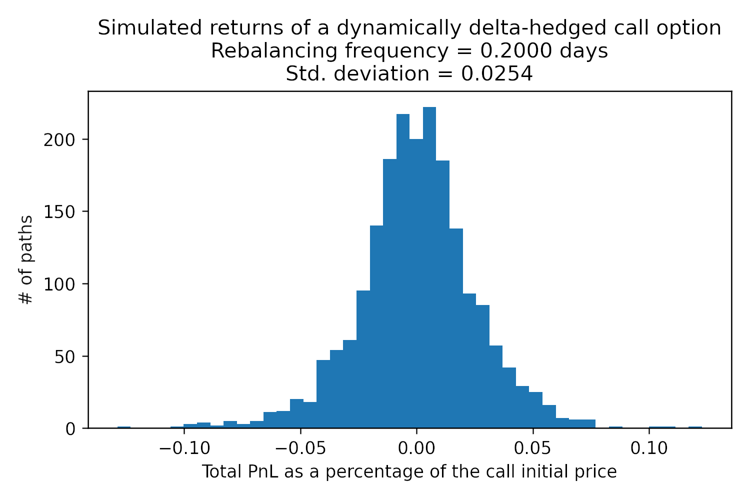

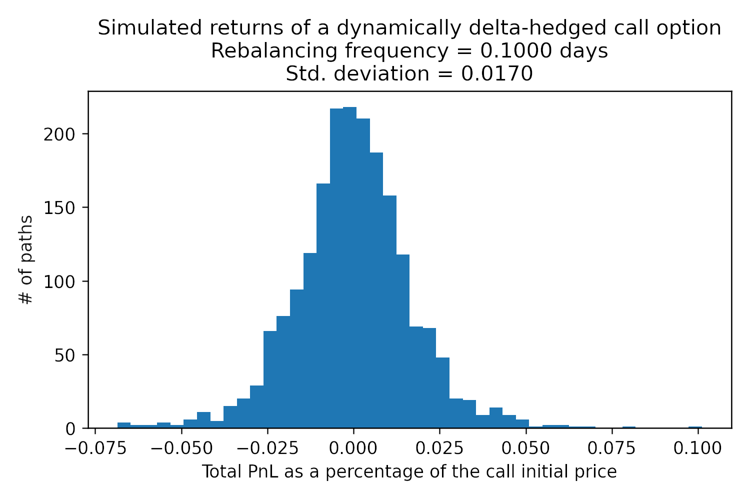

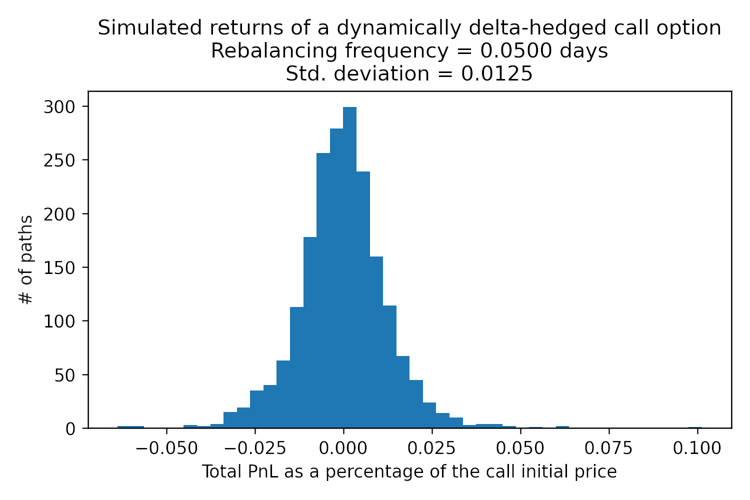

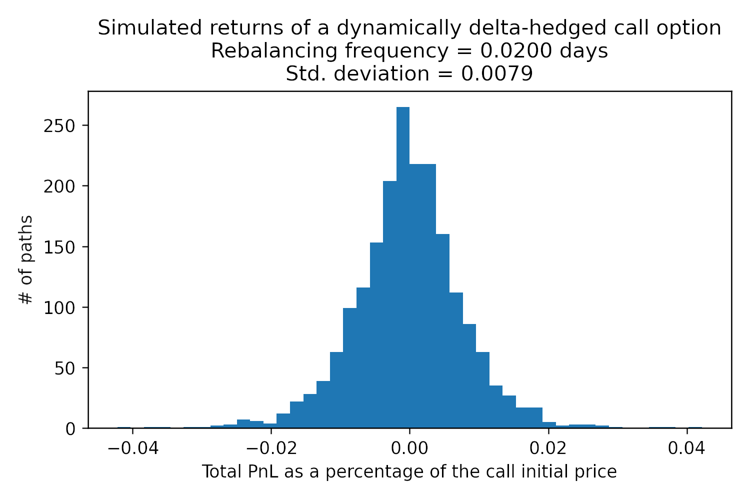

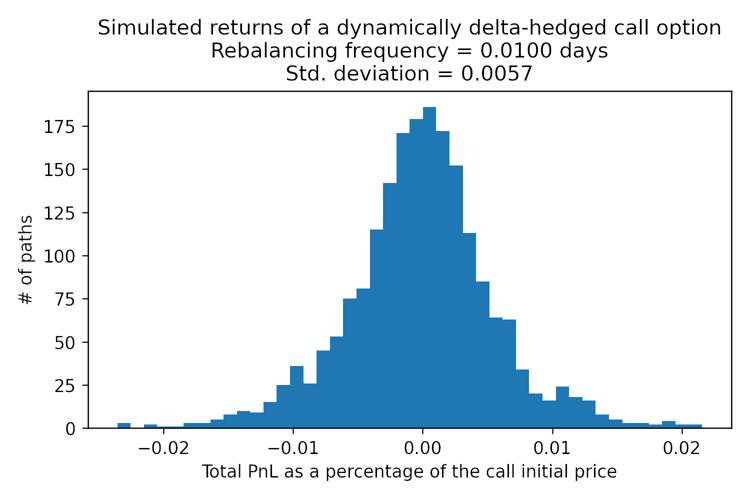

In [67]:
# List of PNG files with the results obtained in each simulation
png_files = ["figs/PnL_distribution_1.0000.png", 
             "figs/PnL_distribution_0.2000.png",
             "figs/PnL_distribution_0.1000.png",
             "figs/PnL_distribution_0.0500.png",
             "figs/PnL_distribution_0.0200.png",
             "figs/PnL_distribution_0.0100.png"]

for file_path in png_files:
    img = Image.open(file_path)
    img_resized = img.resize((750,500))

    display(img_resized)

We see that as we increase the rebalancing frequency the variance of the PnL distribution decreases. That makes total sense since as $dt$ is smaller second order greeks will have less impact on the PnL change.

Another important aspect is to see how PnL distribution changes as rebalancing frequency increases. In next code snippet, I will plot the relationship between rebalancing frequency and PnL distribution variance.

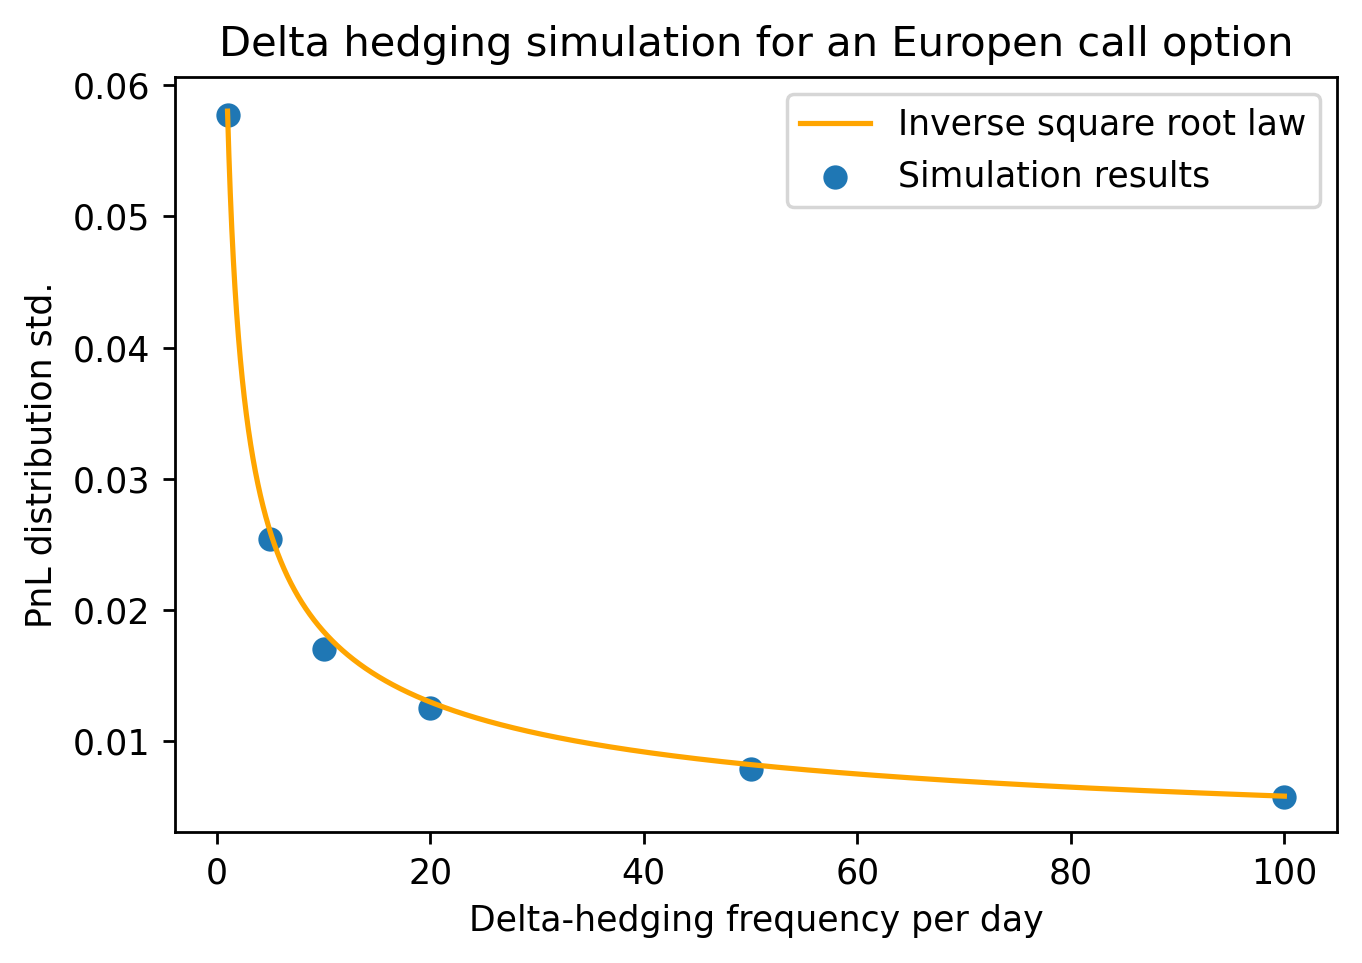

In [84]:
rebal_freq  = [1,5,10,20,50,100] # number of rebalancing times per day
PnL_std     = [0.0577, 0.0254, 0.0170, 0.0125, 0.0079, 0.0057] # PnL distribution std.

# Results are quite similar to an inverse square root, let's fit the coefficient with linear regression
model = LinearRegression()
model.fit((1/np.sqrt(rebal_freq)).reshape(-1, 1), PnL_std)
beta = model.coef_[0]

fig, ax = plt.subplots()
plt.scatter(rebal_freq, PnL_std)
x = np.linspace(1,100,10000)
plt.plot(x, beta/np.sqrt(x), 'orange')
plt.legend(['Inverse square root law','Simulation results'])
plt.xlabel('Delta-hedging frequency per day')
plt.ylabel('PnL distribution std.')
plt.title('Delta hedging simulation for an Europen call option')
plt.savefig('figs/rebal_freq_inv_squareroot.png')

It is seen that delta-hedging frequency follows an inverse square root law with respect to PnL distribution standard deviation. This result makes sense since volatility increases by the square root of time.